NameError: name 'x_min' is not defined

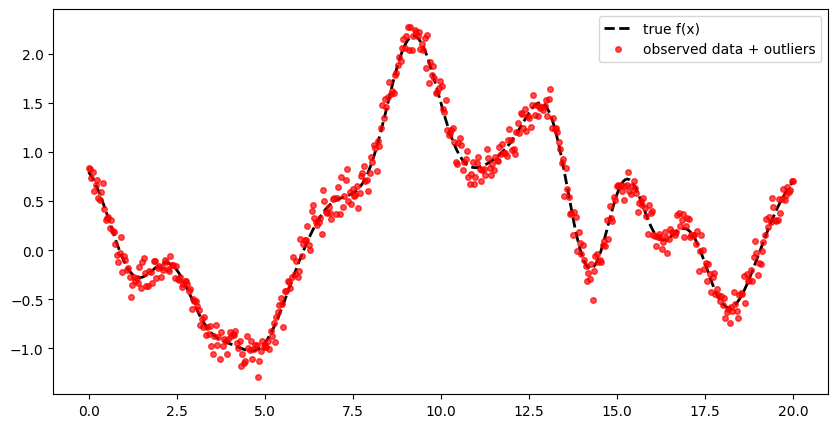

In [1]:
from typing import Optional

import tensorflow as tf
from tensorflow_probability.python.internal.backend.jax import shape

tf.keras.backend.set_floatx('float64')
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random
import numpy as np

from numpy.lib.twodim_base import histogram2d
from scipy.ndimage import variance

from tensorboard.plugins.histogram.summary import histogram
from tensorflow.python.ops.variables import trainable_variables

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 500
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]
"""
arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

upp=2
low=1
y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

# ... [your existing imports and setup code above] ...

# After generating x_obs, y_obs:
"""
"""
# 1. Select 10 outlier positions outside the current data range:
n_outliers = 10
x_min, x_max = float(x.min()), float(x.max())
outlier_spread = 20.0  # how far beyond the range
x_outliers = np.random.uniform(
    low=x_min - outlier_spread,
    high=x_min - 0.1 * outlier_spread,
    size=(n_outliers // 2, 1)
)
x_outliers = np.vstack([
    x_outliers,
    np.random.uniform(
        low=x_max + 0.1 * outlier_spread,
        high=x_max + outlier_spread,
        size=(n_outliers - x_outliers.shape[0], 1)
    )
])

# 2. Assign y-values to outliers (e.g., sample from prior + noise):
#    You can sample from the GP prior covariance or set them arbitrarily
K_xo = kernel(x_outliers, x_outliers)
y_outliers = np.random.multivariate_normal(
    mean=np.zeros(n_outliers),
    cov=K_xo + sigma_n**2 * np.eye(n_outliers)
).reshape(-1, 1)

# 3. Append to the observed data, preserving order:
x_aug = np.vstack([x_obs, x_outliers])
y_aug = np.vstack([y_obs, y_outliers])
order = np.argsort(x_aug[:, 0])
x_obs, y_obs = x_aug[order], y_aug[order]

# Now X and y include the new outliers:
X = x  # untouched original full domain
y = y_obs  # augmented observations

# 4. Plot:
"""
plt.figure(figsize=(10, 5))
plt.plot(x, f, 'k--', lw=2, label='true f(x)')
plt.plot(x_obs, y_obs, 'r.', ms=8, alpha=0.7, label='observed data + outliers')
plt.legend()
plt.xlim(x_min - outlier_spread, x_max + outlier_spread)
plt.show()


In [3]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(x_obs, full_cov=False)

tf.reduce_mean((f_mean-f)**2)

<tf.Tensor: shape=(), dtype=float64, numpy=1.2986775775177215>

In [20]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye*self.sigma**(-2)) @ (self.y-mu_f)
        term3 = N* tf.math.log(self.sigma)
        term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 + term3 + term4 + term5)
     
        return loss
    
    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_xold_xold = kernel.matrix(self.X,self.X)
        K_xold_xnew=kernel.matrix(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [21]:


N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 100, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_GP_alpha(x_obs,y_obs,inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()


<dtype: 'float64'>
<dtype: 'float64'>


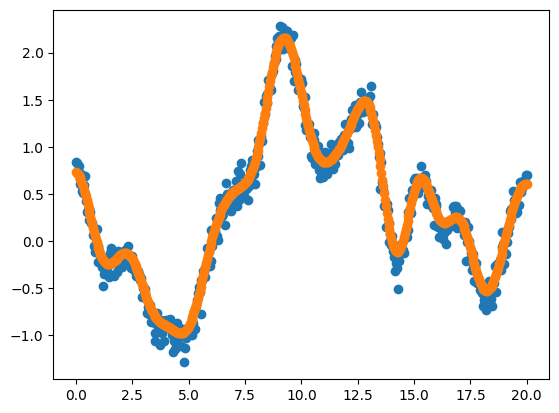

In [6]:
plt.scatter(x_obs,y_obs)
#plt.scatter(x_obs,model.mu_f)
plt.scatter(x_obs,2*tf.linalg.diag_part(model.Sigma_f)+tf.squeeze(model.mu_f))

In [17]:
tf.linalg.diag_part(model.Sigma_f)+model.sigma

<tf.Tensor: shape=(500,), dtype=float64, numpy=
array([0.18673767, 0.18673751, 0.18673744, 0.18673766, 0.1867355 ,
       0.18673753, 0.18673761, 0.18673756, 0.18673747, 0.18673752,
       0.18673256, 0.18673736, 0.18673641, 0.18673745, 0.18673734,
       0.18673758, 0.18673769, 0.18673582, 0.18673738, 0.18668418,
       0.18673742, 0.18669514, 0.18673674, 0.18673729, 0.18673702,
       0.18673727, 0.18673742, 0.18673762, 0.18673553, 0.18673716,
       0.18673747, 0.18670594, 0.18673549, 0.18673665, 0.18673067,
       0.18673736, 0.18673748, 0.18673761, 0.18673743, 0.18673763,
       0.1867376 , 0.18673639, 0.18673748, 0.18669502, 0.18673668,
       0.1867366 , 0.18673708, 0.1867339 , 0.18673611, 0.18673729,
       0.18673654, 0.18673733, 0.18673751, 0.18673755, 0.18673706,
       0.18673577, 0.18673754, 0.18673769, 0.18673358, 0.18673748,
       0.18673728, 0.18673761, 0.18673707, 0.18673745, 0.18673585,
       0.18673159, 0.18673763, 0.18673643, 0.18673759, 0.18673758,
       0.18673

In [8]:
tf.reduce_mean(abs(model.mu_f - f))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9041607584575543>

In [9]:
tf.reduce_mean(abs(f_mean - f))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9149153216953898>

In [16]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGPR_2k_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X = X  # [N, D]
        self.y = y  # [N, 1]
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.variance_q = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale_q = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    

    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)


        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        kernel_q = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance_q, self.lengthscale_q)
        Sigma_u = kernel_q.matrix(self.inducing_variable, self.inducing_variable)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual = self.y - K_fu@K_uu_inv @ mu_u
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u *(Sigma_a_inv @ mu_u))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(self.X, self.X)) - tf.linalg.trace(T1) +tf.linalg.trace(T2))
        term5 = -1.0/(2.0*(self.alpha-1.0)) * (ld_Sig_a + (self.alpha-1.0)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3 +term4 + term5
        return tf.squeeze(loss)

    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        kernel_q = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance_q, self.lengthscale_q)
        Sigma_u = kernel_q.matrix(self.inducing_variable, self.inducing_variable)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        kernel_q = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance_q, self.lengthscale_q)
        K_uu_inv = self.stable_solve(K_uu, I_M)
        Sigma=tf.linalg.diag_part(kernel.matrix(Xnew,Xnew)-K_xu@K_uu_inv@tf.transpose(K_xu)+K_xu@K_uu_inv@self.Sigma_u@K_uu_inv@tf.transpose(K_xu))


        return K_xu@K_uu_inv@self.mu_u
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [3]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 400, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_SGPR_2k_alpha(x_obs, y_obs, inducing_variable, 400)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
preds = model.predict_out(x_obs)

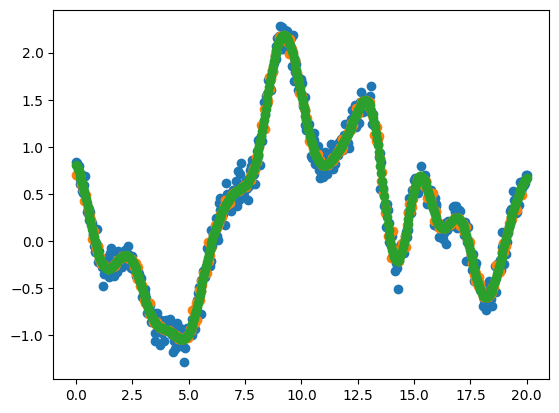

In [4]:
plt.scatter(x_obs,y_obs)
plt.scatter(Z,model.mu_u)
plt.scatter(x_obs,preds)

In [12]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGPR_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X = X  # [N, D]
        self.y = y  # [N, 1]
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.var_q=gpflow.Parameter(np.ones(N_u), transform=gpflow.utilities.positive())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

    

    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = tf.linalg.diag(self.var_q)
        print(Sigma_u.shape)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual = self.y - K_fu@K_uu_inv @ mu_u
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u *(Sigma_a_inv @ mu_u))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(self.X, self.X)) - tf.linalg.trace(T1)+tf.linalg.trace(T2))
        term5 = +1.0/(2.0*(1.0-self.alpha)) * (ld_Sig_a - (1-self.alpha)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3  + term5 +term4
        return tf.squeeze(loss)

    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = tf.linalg.diag(self.var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)
     

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        K_uu_inv = self.stable_solve(K_uu, I_M)
        return K_xu @ K_uu_inv @ self.mu_u
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [6]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 100, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_SGPR_alpha(x_obs, y_obs, inducing_variable, 100)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
preds = model.predict_out(x_obs)

(100, 100)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -720.8606509459223
        x: [ 5.511e-01 -2.284e+00 ... -2.420e+01  4.996e-01]
      nit: 342
      jac: [-2.651e-02  1.319e-02 ... -4.950e-06  1.244e-02]
     nfev: 413
     njev: 413
 hess_inv: <103x103 LbfgsInvHessProduct with dtype=float64>

<tf.Tensor: shape=(), dtype=float32, numpy=1.2499999>

In [42]:
0.05**2*500

1.2500000000000002

In [13]:
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 10000
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.sin(x) + 0.1 * np.random.randn(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

In [17]:
N=x_obs.shape[0]
N_u=100
Z = x_obs[np.random.choice(N, N_u, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_SGPR_alpha(x_obs,y_obs,inducing_variable,N_u)
opt = gpflow.optimizers.Scipy()
#gpflow.set_trainable(model.q_sqrt,False)
opt.minimize(model.train_step, model.trainable_variables)


(100, 100)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -13415.662411685174
        x: [ 2.426e+00 -1.825e+00 ... -3.298e+01 -5.838e+00]
      nit: 992
      jac: [ 5.299e-01  1.696e+00 ... -2.862e-10 -2.620e-01]
     nfev: 1116
     njev: 1116
 hess_inv: <103x103 LbfgsInvHessProduct with dtype=float64>

In [18]:
model.predict_ins()
mu=model.predict_out(x_obs)

AttributeError: 'GVI_SGPR_alpha' object has no attribute 'stable_solve'

NameError: name 'mu' is not defined

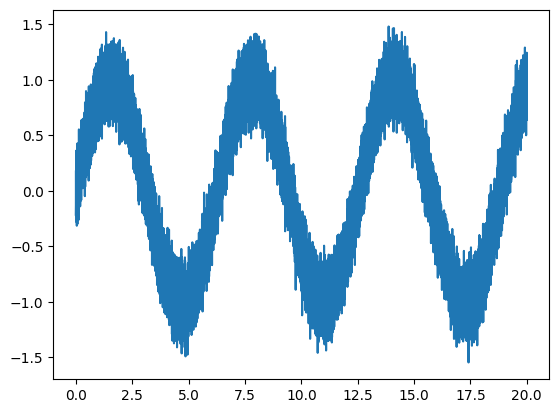

In [31]:
import matplotlib.pyplot as plt
plt.plot(x_obs,y_obs)
plt.plot(x_obs,mu)

In [16]:
standard_gp = gpflow.models.SGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2,
    inducing_variable=Z,
)

opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(x_obs, full_cov=False)

tf.reduce_mean(abs(f_mean-y_obs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.11262210922925886>

In [17]:
tf.reduce_mean(abs(mu-y_obs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.11272188900385237>

In [39]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SVGP_alpha(gpflow.models.BayesianModel):
    def __init__(self, inducing, N_u, alpha=0.5):
        super().__init__()
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.mu_q=gpflow.Parameter(tf.ones((N_u, 1)))
        self.var_q_L=gpflow.Parameter(np.eye(N_u), transform=gpflow.utilities.triangular())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

    

    def train_step(self,X,y):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)


        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = self.var_q_L@tf.transpose(self.var_q_L)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual =y - K_fu@K_uu_inv @ self.mu_q
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(self.mu_q *(Sigma_a_inv @ self.mu_q))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(X,X)) - tf.linalg.trace(T1)+tf.linalg.trace(T2))
        term5 = +1.0/(2.0*(1.0-self.alpha)) * (ld_Sig_a - (1-self.alpha)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3  + term5 +term4
        return tf.squeeze(loss)

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        K_uu_inv = tf.linalg.inv(K_uu+I_M*0.000001)
        return K_xu @ K_uu_inv @ self.mu_q
    
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [54]:

import numpy as np
import tensorflow as tf

try:
    # use legacy Adam optimizer to support old TF versions
    from tensorflow.keras.optimizers.legacy import Adam
except ImportError:
    from tensorflow.keras.optimizers import Adam

import gpflow
from gpflow import set_trainable
from gpflow.ci_utils import reduce_in_tests
from gpflow.models import GPR, SGPR, SVGP, VGP
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers.natgrad import XiSqrtMeanVar
def train_svgp_model(svgp_model, dataset, num_iterations, learning_rate=0.01):
    """
    Train a GVI_SVGP_alpha model using Adam for model parameters and optionally
    a different optimizer for variational parameters.
    """
    # Create iterators
    dataset_iter = iter(dataset)

    # Optimizers
    adam = tf.optimizers.Adam(learning_rate)

    loss_trace = []
    model_params = [
    svgp_model.variance.variable,
    svgp_model.lengthscale.variable,
    svgp_model.sigma.variable,
    ]

    variational_params = [
        (svgp_model.mu_q,
        svgp_model.var_q_L)
    ]
    for step in range(num_iterations):
        X_batch, y_batch = next(dataset_iter)

        with tf.GradientTape() as tape:
            loss = svgp_model.train_step(X_batch, y_batch)
        grads = tape.gradient(loss, model_params)
        adam.apply_gradients(zip(grads, model_params))

        # Optional: separate step for variational params (e.g. manual natural gradient step)
        with tf.GradientTape() as tape_var:
            loss_var = svgp_model.train_step(X_batch, y_batch)
        grads_var = tape_var.gradient(loss_var, variational_params)
        adam.apply_gradients(zip(grads_var, variational_params))  # Replace with natgrad if desired

        if step % 10 == 0:
            print(f"Step {step}: Loss = {loss.numpy():.4f}")
            loss_trace.append(loss.numpy())

    return loss_trace

N_u=100
Z = x_obs[np.random.choice(N, N_u, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)

svgp_model=GVI_SVGP_alpha(inducing_variable,N_u)


variational_params = [svgp_model.mu_q.unconstrained_variable, svgp_model.var_q_L.unconstrained_variable]

data = tf.data.Dataset.from_tensor_slices((x_obs, y_obs))
autotune = tf.data.AUTOTUNE
batch_size = 128




In [55]:
data_minibatch = (
    data
    .shuffle(N)
    .repeat()
    .batch(batch_size)
    .prefetch(autotune)
)

loss_history = train_svgp_model(svgp_model, data_minibatch, num_iterations=100)

AttributeError: 'Parameter' object has no attribute 'variable'